In [1]:
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.io.cif import CifParser
from pymatgen.io.vasp import Poscar
from pymatgen.io.cif import CifWriter
from pymatgen.io.xyz import XYZ
from pymatgen.io.gaussian import GaussianInput
import numpy as np
import os
from matplotlib import pyplot as plt


species_index_dict = {
    'C': 1,
    'Li': 2
}

species_labels_dict = {
    'C': f"{species_index_dict['C']} 6  C-gga",
    'Li': f"{species_index_dict['Li']} 3  Li-gga"
}

In [2]:
strains = np.arange(-0.5, 0.5, 0.01)

In [3]:
structures = {}
for strain in strains:
    graphite = Structure.from_file('graphite.3x3x1.cif')
    graphite.apply_strain([0, 0, strain])
    structures[strain] = graphite

## Write inputs for SZ with grimm correction

In [ ]:
for strain in strains:
    file=f"./graphite_scan/graphite.{round(strain,2)}_zStrain.fdf"
    
    os.system(f"cat graphite.siesta_template_head.txt > {file}")

    with open(file, "a") as f:
        f.write('\n\nLatticeConstant 1.000000 Ang\n')
        f.write('%block LatticeVectors\n')
        for i in structures[strain].lattice.as_dict()['matrix']:
            f.write(f"\t{i[0]:.10f}\t{i[1]:.10f}\t{i[2]:.10f}\n")
        f.write('%endblock LatticeVectors\n\n')
        f.write('AtomicCoordinatesFormat Ang\n')
        f.write('%block AtomicCoordinatesAndAtomicSpecies\n')
        for i in structures[strain].sites:
            coord = i.coords
            f.write(f"\t{coord[0]:.8f}\t{coord[1]:.8f}\t{coord[2]:.8f}\t{species_index_dict[i.species_string]}\n")
        f.write('%endblock AtomicCoordinatesAndAtomicSpecies\n\n')

    os.system(f"cat graphite.siesta_template_tail.txt >> {file}")

## Write inputs for SZ with 4x4x4 scan

In [12]:
for strain in strains:
    file=f"./graphite_4x4x4_scan/graphite.{round(strain,2)}_zStrain.fdf"
    
    os.system(f"cat graphite.siesta_template_head.txt > {file}")

    with open(file, "a") as f:
        f.write('\n\nLatticeConstant 1.000000 Ang\n')
        f.write('%block LatticeVectors\n')
        for i in structures[strain].lattice.as_dict()['matrix']:
            f.write(f"\t{i[0]:.10f}\t{i[1]:.10f}\t{i[2]:.10f}\n")
        f.write('%endblock LatticeVectors\n\n')
        f.write('AtomicCoordinatesFormat Ang\n')
        f.write('%block AtomicCoordinatesAndAtomicSpecies\n')
        for i in structures[strain].sites:
            coord = i.coords
            f.write(f"\t{coord[0]:.8f}\t{coord[1]:.8f}\t{coord[2]:.8f}\t{species_index_dict[i.species_string]}\n")
        f.write('%endblock AtomicCoordinatesAndAtomicSpecies\n\n')

    os.system(f"cat graphite.4x4x4.siesta_template_tail.txt >> {file}")

### Plot results

lowest energy = -5541.851008
Bottom of well = [5.301690000000002]


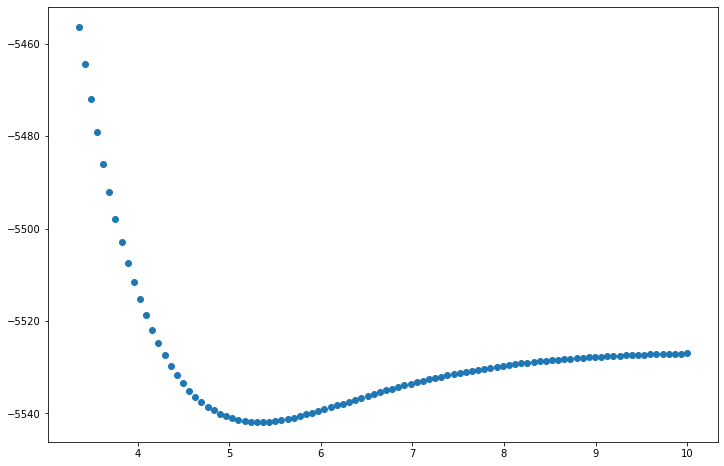

In [17]:
energies = []
for strain in strains:
    with open(f"./graphite_4x4x4_scan/outputs/OUT.graphite.{round(strain,2)}_zStrain") as f:
        for line in f:
            if "siesta:         Total =" in line:
                energies.append(float(line.strip().split()[3]))

z_distance = [6.711 * (1+s) for s in strains]

print(f"lowest energy = {np.min(energies)}")
mindist = [z_distance[i] for i,j in enumerate(energies) if j == np.min(energies)]
print(f"Bottom of well = {mindist}")

plt.figure(figsize=(12,8))
plt.scatter(z_distance,energies)
plt.show()

#### WTF

## Repeat for 4x4x4 grid with DZP

In [ ]:
strains = np.arange(-0.5, 0.5, 0.01)

In [19]:
for strain in strains:
    file=f"./graphite_dzp_scan/graphite.{round(strain,2)}_zStrain.fdf"
    
    os.system(f"cat graphite.DZP.siesta_template_head.txt > {file}")

    with open(file, "a") as f:
        f.write('\n\nLatticeConstant 1.000000 Ang\n')
        f.write('%block LatticeVectors\n')
        for i in structures[strain].lattice.as_dict()['matrix']:
            f.write(f"\t{i[0]:.10f}\t{i[1]:.10f}\t{i[2]:.10f}\n")
        f.write('%endblock LatticeVectors\n\n')
        f.write('AtomicCoordinatesFormat Ang\n')
        f.write('%block AtomicCoordinatesAndAtomicSpecies\n')
        for i in structures[strain].sites:
            coord = i.coords
            f.write(f"\t{coord[0]:.8f}\t{coord[1]:.8f}\t{coord[2]:.8f}\t{species_index_dict[i.species_string]}\n")
        f.write('%endblock AtomicCoordinatesAndAtomicSpecies\n\n')

    os.system(f"cat graphite.4x4x4.siesta_template_tail.txt >> {file}")

lowest energy = -5581.93926
Bottom of well = [6.375450000000003]


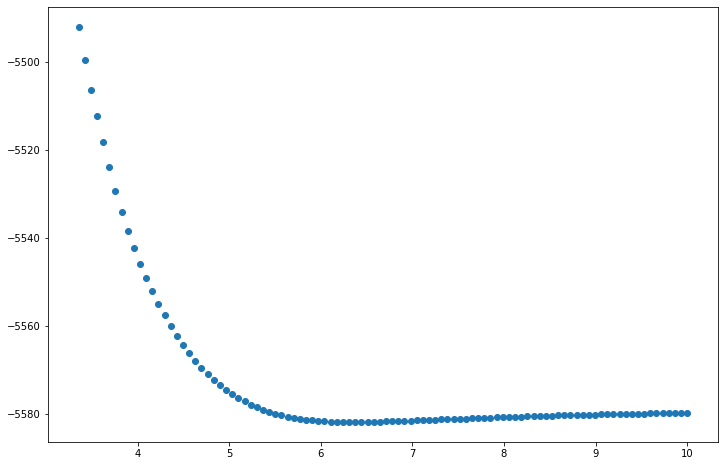

In [20]:
energies = []
for strain in strains:
    with open(f"./graphite_dzp_scan/outputs/OUT.graphite.{round(strain,2)}_zStrain") as f:
        for line in f:
            if "siesta:         Total =" in line:
                energies.append(float(line.strip().split()[3]))

z_distance = [6.711 * (1+s) for s in strains]

print(f"lowest energy = {np.min(energies)}")
mindist = [z_distance[i] for i,j in enumerate(energies) if j == np.min(energies)]
print(f"Bottom of well = {mindist}")

plt.figure(figsize=(12,8))
plt.scatter(z_distance,energies)
plt.show()

-5579.873605